# Conformalized Quantile Regression

In [1]:
# All libraries are imported from the python file 'libraries' 
# we seperated it from the notebook for shortening 
from libraries import *

2022-08-22 10:23:17.613312: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 10:23:17.619037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 10:23:17.619050: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load & Preprocess data

In [3]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)

#Split data into training and testing sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Training Data : (8817, 753)
Testing Data  : (980, 753)



## CQR Model using MAPIE

In [4]:
# CHOOSE THE RISK LEVEL ALPHA WHICH REPRESENTS 1-ALPHA CONFIDENCE.
alpha = 0.1

#instanciate the Quantile Regressor from MAPIE
#keep it empty to choose default regression algorithm = 'QuantileRegression'
model = MapieQuantileRegressor(method="quantile", alpha = alpha)

#fit the model
g = model.fit(X_train, y_train, random_state=1)

In [5]:
mediane = g.estimators_[2].predict(X_test)

In [6]:
# predict test set and return the prediction and the lower, upper bounds ( y_pis )
y_pred, y_pis = model.predict(X_test, alpha=alpha)

# predict train set and return the prediction and the lower, upper bounds ( y_pis )
y_pred_train, y_pis_train = model.predict(X_train, alpha=alpha)

In [7]:
#split y_pis to get the lower bound and the upper bound of the TEST set
lower = y_pis[:, 0, :]
lower = lower.reshape(y_test.shape)
upper = y_pis[:, 1, :]
upper = upper.reshape(y_test.shape)


#split y_pis to get the lower bound and the upper bound of the TRAIN set
lower_train = y_pis_train[:, 0, :]
lower_train = lower_train.reshape(y_train.shape)

upper_train = y_pis_train[:, 1, :]
upper_train = upper_train.reshape(y_train.shape)

In [8]:
print(f"{lower.shape}{upper.shape}{y_test.shape}")
print(f"{lower_train.shape}{upper_train.shape}{y_train.shape}")

(980,)(980,)(980,)
(8817,)(8817,)(8817,)


In [9]:
def compute_coverage_len(y_test, y_lower, y_upper):
    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / len(y_test) * 100
    avg_length = np.mean(abs(y_upper - y_lower))
    return coverage, avg_length

In [10]:
coverage_test, avg_length_test = compute_coverage_len(list(y_test), lower, upper)
coverage_train, avg_length_train = compute_coverage_len(y_train, lower_train, upper_train)

In [11]:
print(f" The coverage of the test set is : {round(coverage_test,7)}% \n The average lenght is : {round(avg_length_test,5)}")

print(f"\n The coverage of the train set is : {round(coverage_train,5)}% \n The average lenght is : {round(avg_length_train,5)}")

 The coverage of the test set is : 91.0204082% 
 The average lenght is : 9.0503

 The coverage of the train set is : 94.3745% 
 The average lenght is : 8.77471


<AxesSubplot:xlabel='Residual error', ylabel='Density'>

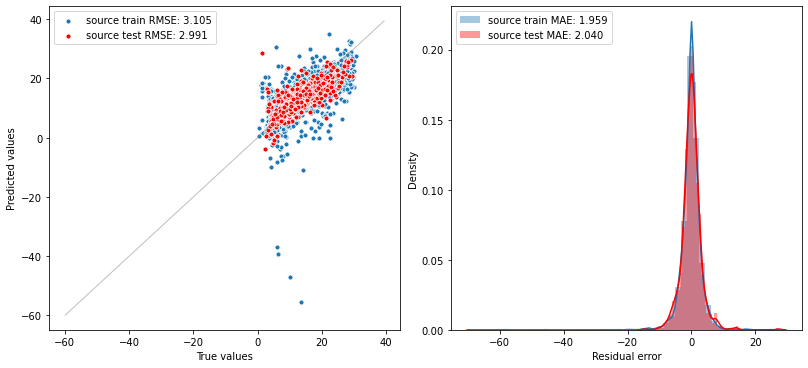

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); 

plot_adequation(y_train, y_pred_train, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, y_pred, label='source test', ax=ax1, plot_line=False, score='RMSE', color='red')



plot_residuals(y_train, y_pred_train, kind='hist', label='source train', ax=ax2, score='MAE')
plot_residuals(y_test, y_pred, kind='hist', label='source test', ax=ax2, score='MAE', color='red')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

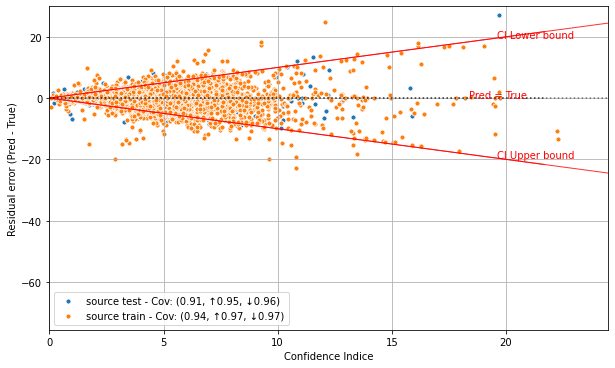

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(24, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
plt.grid(True)

plot_confidence_v2(y_test,y_pred , lower,  upper, ax=ax1, label='source test')
plot_confidence_v2(y_train,y_pred_train , lower_train,  upper_train,ax = ax1, label='source train')


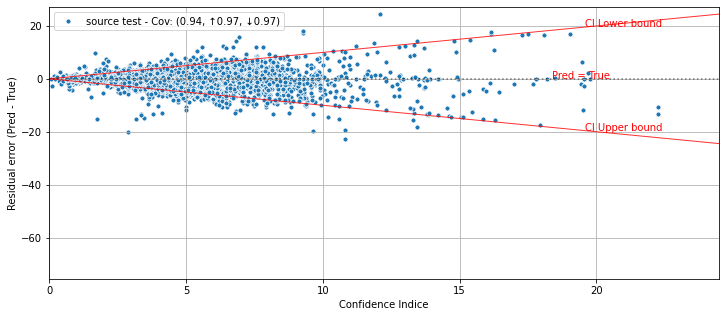

In [14]:
plot_confidence_v2(y_train,y_pred_train , lower_train,  upper_train, label='source test')
plt.grid(True)

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

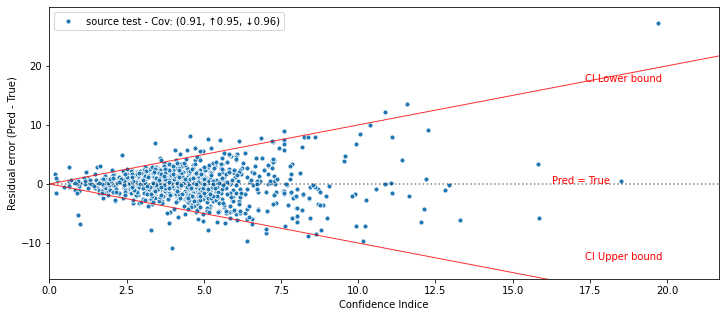

In [15]:
plot_confidence_v2(y_test,y_pred , lower,  upper, label='source test')

Text(0.5, 0, 'Confidence Indice')

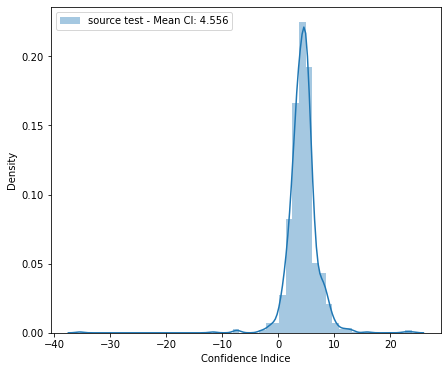

In [16]:
#plot_residuals(y_train_pred, y_train_q95, kind='hist', label='source train - Mean CI:', score=mean_absolute_error, ax=ax5)
plot_residuals(y_pred, upper, kind='hist', label='source test - Mean CI:', score=mean_absolute_error)
plt.xlabel("Confidence Indice")

In [17]:
def compute_coverage(y_test,y_lower,y_upper,significance,name=""):
    """ Compute average coverage and length, and print results
    Parameters
    ----------
    y_test : numpy array, true labels (n)
    y_lower : numpy array, estimated lower bound for the labels (n)
    y_upper : numpy array, estimated upper bound for the labels (n)
    significance : float, desired significance level
    name : string, optional output string (e.g. the method name)
    Returns
    -------
    coverage : float, average coverage
    avg_length : float, average length
    """
    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / len(y_test) * 100
    print("%s: Percentage in the range (expecting %.2f): %f" % (name, 100 - significance*100, coverage))
    sys.stdout.flush()

    avg_length = abs(np.mean(y_lower - y_upper))
    print("%s: Average length: %f" % (name, avg_length))
    sys.stdout.flush()
    return coverage, avg_length

In [18]:
import sys

In [19]:
a,b = compute_coverage(y_test,lower,upper, 0.05)

: Percentage in the range (expecting 95.00): 91.020408
: Average length: 8.569057


In [20]:
p0_05 = lower.copy()
p0_5 = mediane.copy()
p0_95 = upper.copy()

## Estimate the Mean and the variance from quantiles

In this case, as the method do not output the variance which we need to compute several metrics with, we used the **Extended Pearson-Tukey method**

By having $p_{0.05}, p_{0.5}$ and $p_{0.95}$
$$\hat{\mu} = 0.630.p_{0.5} + 0.185.(p_{0.05}+p_{0.95}) $$
$$ \hat{\sigma}^2 = 0.630(p_{0.5}-\hat{\mu})+0.185[(p_{0.05}-\hat{\mu})^2 + (p_{0.95}-\hat{\mu})^2] $$

In [27]:
def pearson_tukey(p0_05, p0_5, p0_95):
    mu = 0.63*p0_5 + 0.185*(p0_05+p0_95)
    std = 0.63*(p0_5-mu)**2+0.185*((p0_05-mu)**2 + (p0_95-mu)**2)
    return mu, std

In [35]:
mu, stds = pearson_tukey(p0_05, p0_5, p0_95)

In [36]:
import seaborn as sns

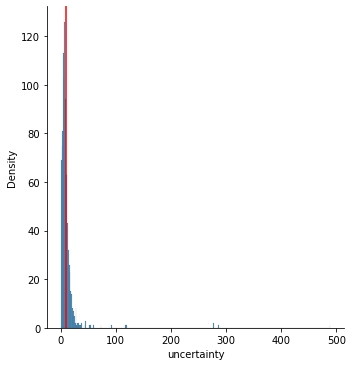

In [37]:
#plt.figure(figsize=(10,8))
sns.displot(stds)
plt.axvline(np.mean(stds), color='red')
#plt.legend(['mean of stdvs','std for each tire preds'])
plt.xlabel("uncertainty")
plt.ylabel("Density")
plt.show()

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

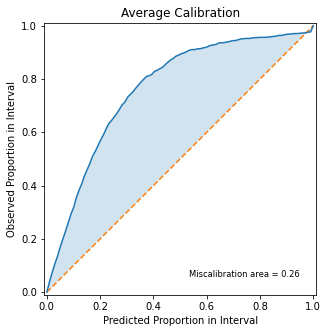

In [38]:
uct.viz.plot_calibration(np.array(y_pred),  np.array(stds), np.array(y_test))

## Calibration

In [39]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(y_pred), np.array(stds), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

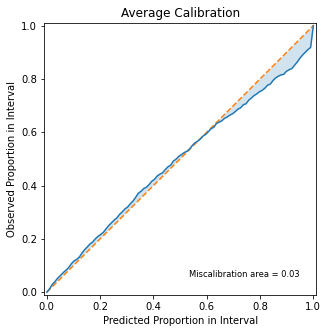

In [40]:
uct.viz.plot_calibration(np.array(y_pred),  np.array(new_stds), np.array(y_test))

In [41]:
all_metrics_calib = uct.get_all_metrics(np.array(y_pred),np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.040
  RMSE          2.991
  MDAE          1.428
  MARPD         16.690
  R2            0.562
  Correlation   0.752
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.034
  Mean-absolute Calibration Error       0.026
  Miscalibration Area                   0.026
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.056
     Group Size: 0.56 -- Calibration Error: 0.035
     Group Size: 1.00 -- Calibration Error: 0.026
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.043
     Group Size: 1.00 -- Calibration Error: 0.034
===============

### Save metrics

In [44]:
import pickle

In [45]:
with open('CQR_metrics_sparse.pkl', 'wb') as f:
    pickle.dump(all_metrics_calib, f)